# **Necessary Imports**

In [2]:
# Necessary Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import os  # For dynamic file path handling

# Set file paths
dataset_path = "processed_customer_data.csv"  # Updated file name
model_path = "clustering.joblib"

# Check if dataset exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"{dataset_path} not found. Please ensure the file is in the working directory.")

# Read the dataset
df = pd.read_csv(dataset_path)
print(df.head())



   Index  UnitPrice  Quantity        F3        F4    F5    F6    F7    F8  \
0      1   0.224506  0.500340  0.489860  0.902413  7934 -6970 -5714  9982   
1      2   0.321128  0.281119  0.907283  0.772159 -8238  1219  1663  1287   
2      3   0.893441  0.622005  0.998776  0.098386  8540  5266 -9377 -3504   
3      4   0.320641  0.957234  0.346000  0.646479 -7772  -383  9681 -8661   
4      5   0.475961  0.623008  0.544988  0.159709  1571 -8039 -7961 -2385   

     F9  ...        F15         F16  F17  F18  F19  F20 F21  F22  C  \
0 -5697  ...  10/4/1986    9/6/1992    2    1  706  305   1    2  0   
1 -3658  ...  2/24/1979    1/5/1983    1    1  423  206  18    7  1   
2 -4511  ...  1/12/1989  11/22/1986    2    1  703  315   1    4  0   
3  3474  ...  2/18/1982   6/10/1992    1    1  122  304  15    1  0   
4  4407  ...  4/10/1987  10/19/1985    1    1  486  240   1    1  0   

   Revenue_given  
0       0.112329  
1       0.090275  
2       0.555725  
3       0.306928  
4       0.29652

# **Model class Initialization**

## **We will be creating an ensemble clustering algorithm using 2 individual clustering algorithms. Then with the help of maximum voting, we will decide the final value**
* K-Means
* K-Medoids

### **K-Means Clustring class**  

In [3]:
class KMeans:
    """
    Custom implementation of K-Means clustering.
    """
    def __init__(self):
        """
        Initialize KMeans with empty centroids.
        """
        self.centroids = None

    def fit(self, data, clusters, random_seed=42):
        """
        Fits the KMeans model to the data.

        Args:
            data (np.ndarray): The dataset to cluster.
            clusters (int): Number of clusters.
            random_seed (int): Seed for reproducibility.

        Returns:
            np.ndarray: Cluster labels for the dataset.
        """
        np.random.seed(random_seed)
        N, D = data.shape
        self.centroids = data[np.random.choice(N, clusters, replace=False), :]
        
        labels = np.zeros(N)
        while True:
            # Compute distances and assign clusters
            distances = np.linalg.norm(data[:, None] - self.centroids, axis=2)
            new_labels = np.argmin(distances, axis=1)
            
            # Update centroids
            for k in range(clusters):
                self.centroids[k] = data[new_labels == k].mean(axis=0)
            
            # Check for convergence
            if np.all(labels == new_labels):
                break
            labels = new_labels
        return labels

    def predict(self, data):
        """
        Predict cluster labels for new data points.

        Args:
            data (np.ndarray): New data points.

        Returns:
            np.ndarray: Predicted cluster labels.
        """
        distances = np.linalg.norm(data[:, None] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)


### **K-Medoids Clustering class**

In [4]:
class KMedoids:
    """
    Custom implementation of K-Medoids clustering.
    """
    def __init__(self, data, clusters):
        """
        Initialize KMedoids with the dataset and number of clusters.
        """
        self.data = data
        self.clusters = clusters
        self.medoids = None

    def fit(self, random_seed=42):
        """
        Fits the KMedoids model to the data.

        Args:
            random_seed (int): Seed for reproducibility.

        Returns:
            np.ndarray: Cluster labels for the dataset.
        """
        np.random.seed(random_seed)
        N, D = self.data.shape
        medoids_idx = np.random.choice(N, self.clusters, replace=False)
        self.medoids = self.data[medoids_idx]
        
        while True:
            # Assign clusters
            distances = np.linalg.norm(self.data[:, None] - self.medoids, axis=2)
            labels = np.argmin(distances, axis=1)
            
            # Update medoids
            for k in range(self.clusters):
                cluster_points = self.data[labels == k]
                medoid_costs = np.sum(np.linalg.norm(cluster_points[:, None] - cluster_points, axis=2), axis=1)
                self.medoids[k] = cluster_points[np.argmin(medoid_costs)]
            
            # Check for convergence
            if np.array_equal(labels, np.argmin(distances, axis=1)):
                break
        return labels

    def predict(self, data):
        """
        Predict cluster labels for new data points.

        Args:
            data (np.ndarray): New data points.

        Returns:
            np.ndarray: Predicted cluster labels.
        """
        distances = np.linalg.norm(data[:, None] - self.medoids, axis=2)
        return np.argmin(distances, axis=1)


### **Ensemble Clustering Class**

In [6]:
class EnsembleClustering:
    """
    Ensemble clustering using K-Means and K-Medoids.
    """
    def __init__(self, data, clusters):
        self.data = data
        self.clusters = clusters
        self.kmeans = None
        self.kmedoids = None

    def fit(self):
        """
        Fit both KMeans and KMedoids and combine results via majority voting.
        """
        self.kmeans = KMeans()
        kmeans_labels = self.kmeans.fit(self.data, self.clusters)

        self.kmedoids = KMedoids(data=self.data, clusters=self.clusters)
        kmedoids_labels = self.kmedoids.fit()

        return self._maximum_voting(kmeans_labels, kmedoids_labels)

    def _maximum_voting(self, labels1, labels2):
        """
        Perform majority voting between two clustering results.
        """
        final_labels = np.zeros_like(labels1)
        for i in range(len(labels1)):
            votes = [labels1[i], labels2[i]]
            final_labels[i] = max(set(votes), key=votes.count)
        return final_labels

    def predict(self, data):
        """
        Predict cluster labels for new data points using ensemble clustering.
        """
        kmeans_labels = self.kmeans.predict(data)
        kmedoids_labels = self.kmedoids.predict(data)
        return self._maximum_voting(kmeans_labels, kmedoids_labels)


# **Reading csv file**

   Index        F1        F2        F3        F4    F5    F6    F7    F8  \
0      1  0.224506  0.500340  0.489860  0.902413  7934 -6970 -5714  9982   
1      2  0.321128  0.281119  0.907283  0.772159 -8238  1219  1663  1287   
2      3  0.893441  0.622005  0.998776  0.098386  8540  5266 -9377 -3504   
3      4  0.320641  0.957234  0.346000  0.646479 -7772  -383  9681 -8661   
4      5  0.475961  0.623008  0.544988  0.159709  1571 -8039 -7961 -2385   

     F9  ...         F14        F15        F16  F17  F18  F19  F20  F21  F22  \
0 -5697  ... -3433637453  528768000  715737600    2    1  706  305    1    2   
1 -3658  ...   609277486  288662400  410572800    1    1  423  206   18    7   
2 -4511  ... -8977995005  600566400  533001600    2    1  703  315    1    4   
3  3474  ...  4868760308  382838400  708134400    1    1  122  304   15    1   
4  4407  ...  9757408267  545011200  498528000    1    1  486  240    1    1   

   C  
0  0  
1  1  
2  0  
3  0  
4  0  

[5 rows x 24 column

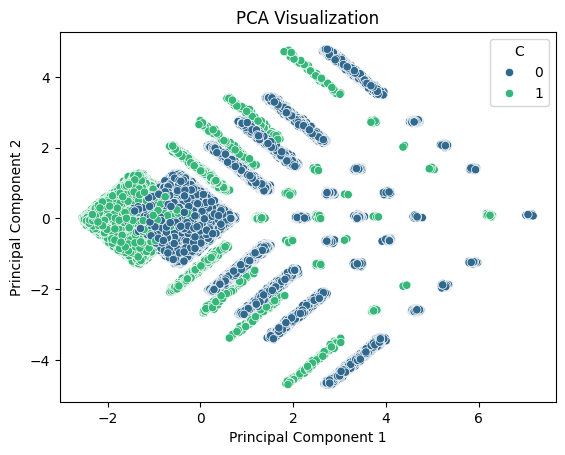

In [11]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns



# Provide the full path to the file
file_path = r"C:\Users\adity\price-comparison-project\Dataset.txt"

# Adjust the delimiter based on the structure of your file (e.g., ',', '\t', etc.)
df = pd.read_csv(file_path, delimiter="\t")  # Replace "\t" with the correct delimiter if needed

# Display the first few rows of the dataframe


# Convert date columns F15 and F16 to numeric timestamp

# Convert date columns F15 and F16 to numeric timestamps in seconds
df['F15'] = pd.to_datetime(df['F15'], format='%m/%d/%Y').astype('int64') // 10**9
df['F16'] = pd.to_datetime(df['F16'], format='%m/%d/%Y').astype('int64') // 10**9

# Display the updated dataframe
print(df.head())


# Drop 'Index' column if not relevant; adjust if needed
df_numeric = df.drop(columns=['Index'])

# Standardize the dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

# Apply PCA
pca = PCA(n_components=2, random_state=42)
train_features = pca.fit_transform(scaled_data)

# Output the PCA-transformed features
print("Transformed features (first 5 rows):")
print(train_features[:5])

# Visualize the PCA results
sns.scatterplot(x=train_features[:, 0], y=train_features[:, 1], hue=df['C'], palette='viridis')
plt.title("PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


# **Saving model**

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load the dataset
df = pd.read_csv(r"C:\Users\adity\price-comparison-project\Dataset.txt", delimiter="\t")

# Convert date columns 'F15' and 'F16' to datetime objects (optional)
df['F15'] = pd.to_datetime(df['F15'], errors='coerce')  # Handle invalid dates
df['F16'] = pd.to_datetime(df['F16'], errors='coerce')  # Handle invalid dates

# Convert datetime columns to Unix timestamps (seconds since epoch)
df['F15'] = df['F15'].astype('int64') // 10**9  # Convert to seconds since epoch
df['F16'] = df['F16'].astype('int64') // 10**9   # Convert to seconds since epoch

# Drop 'Index' column if it's not relevant for prediction
X = df.drop(columns=['Index', 'C'])  # Features (excluding 'Index' and target 'C')
y = df['C']  # Target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model (RandomForestClassifier as an example)
model = RandomForestClassifier()

# Train the model
model.fit(X_train, y_train)

# Generate predictions for training and test datasets
train_predictions = model.predict(X_train)  # Predictions for training data
test_predictions = model.predict(X_test)    # Predictions for test data

# Create DataFrame for training predictions
train_results = pd.DataFrame({'Index': df.loc[X_train.index, 'Index'], 'Class': train_predictions})

# Create DataFrame for test predictions
test_results = pd.DataFrame({'Index': df.loc[X_test.index, 'Index'], 'Class': test_predictions})

# Save the predictions to text files
train_results.to_csv('train_predictions.txt', sep='\t', index=False, header=False)
test_results.to_csv('test_predictions.txt', sep='\t', index=False, header=False)

print("Predictions saved to 'train_predictions.txt' and 'test_predictions.txt'.")


Predictions saved to 'train_predictions.txt' and 'test_predictions.txt'.
